In [14]:
import numpy as np
np.float_ = np.float64
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet


from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use("ggplot")
plt.style.use("fivethirtyeight")

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculte MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true). np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
pjme = pd.read_csv('./PJME_hourly.csv',
                   index_col=[0],
                   parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


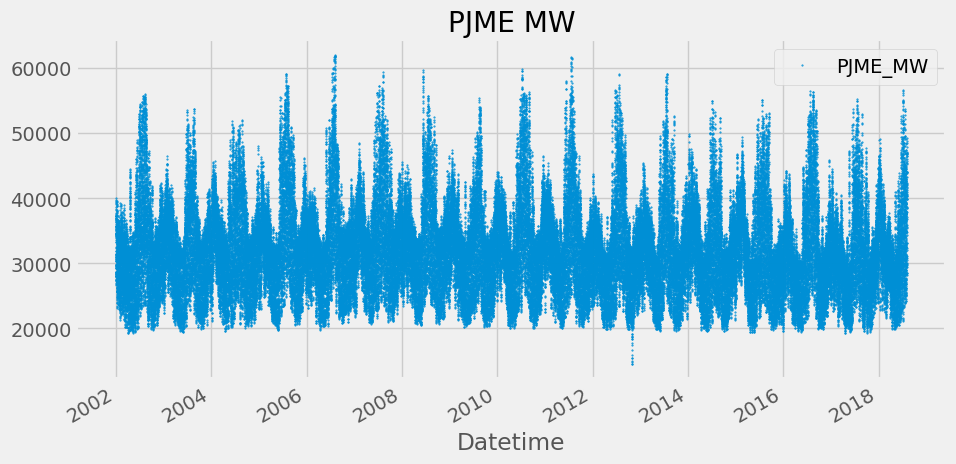

In [20]:
color_pal = sns.color_palette()
pjme.plot(style=' .',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

In [30]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday', 
                                        'Wednesday',
                                        'Thursday', 'Friday',
                                        'Saturday', 'Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """

    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 * df.date.dt.day -320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                        labels=['Spring', 'Summer', 'Fall', 'Winter']
                    )
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear', 'weekday',
            'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)
    

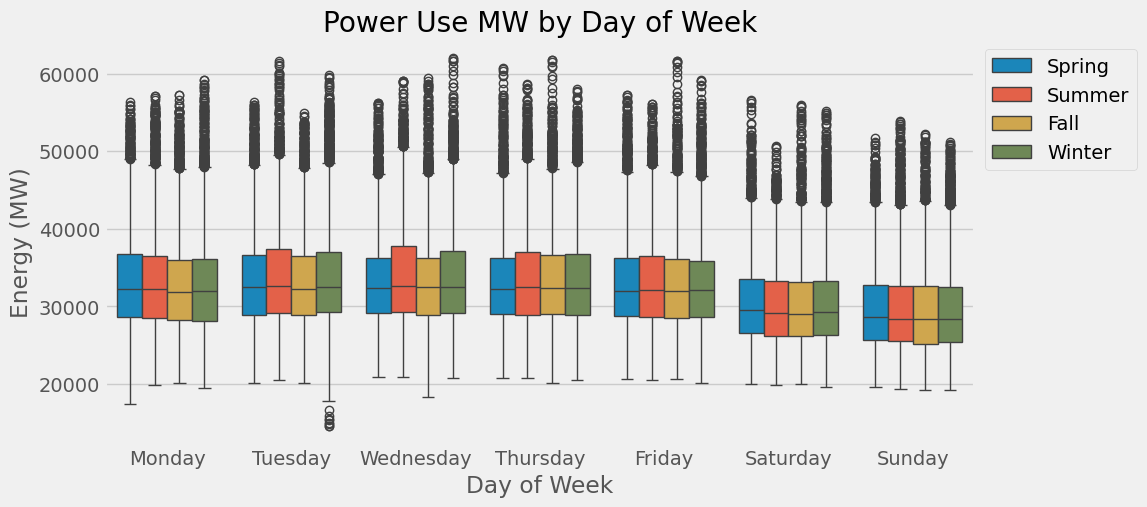

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

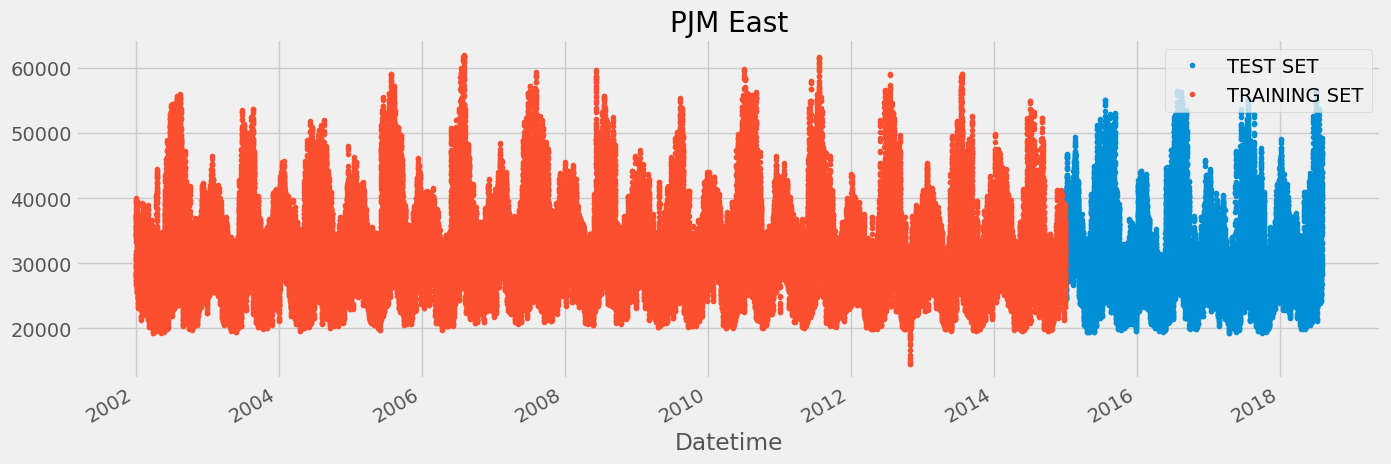

In [38]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

#Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15, 5), title='PJM East', style='.')
plt.show()

In [40]:
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [43]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:53:00 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 19.5 s
Wall time: 3min 8s


In [45]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
               'PJME_MW':'y'})
pjme_test_fcast = model.predict(pjme_test_prophet)

In [49]:
pjme_test_fcast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31214.420813,24105.628217,32783.741660,31214.420813,31214.420813,-2835.417939,-2835.417939,-2835.417939,-4430.360197,...,1281.390107,1281.390107,1281.390107,313.552151,313.552151,313.552151,0.0,0.0,0.0,28379.002874
1,2015-01-01 02:00:00,31214.383693,22203.606977,31457.098508,31214.383693,31214.383693,-4339.789544,-4339.789544,-4339.789544,-5927.274407,...,1272.632061,1272.632061,1272.632061,314.852802,314.852802,314.852802,0.0,0.0,0.0,26874.594149
2,2015-01-01 03:00:00,31214.346573,21493.372194,30297.973700,31214.346573,31214.346573,-5211.485567,-5211.485567,-5211.485567,-6790.348748,...,1262.668237,1262.668237,1262.668237,316.194944,316.194944,316.194944,0.0,0.0,0.0,26002.861007
3,2015-01-01 04:00:00,31214.309453,21172.164928,30202.054514,31214.309453,31214.309453,-5353.038520,-5353.038520,-5353.038520,-6922.239359,...,1251.622235,1251.622235,1251.622235,317.578604,317.578604,317.578604,0.0,0.0,0.0,25861.270933
4,2015-01-01 05:00:00,31214.272334,21798.191505,31076.771958,31214.272334,31214.272334,-4678.701426,-4678.701426,-4678.701426,-6237.335097,...,1239.629865,1239.629865,1239.629865,319.003806,319.003806,319.003806,0.0,0.0,0.0,26535.570907


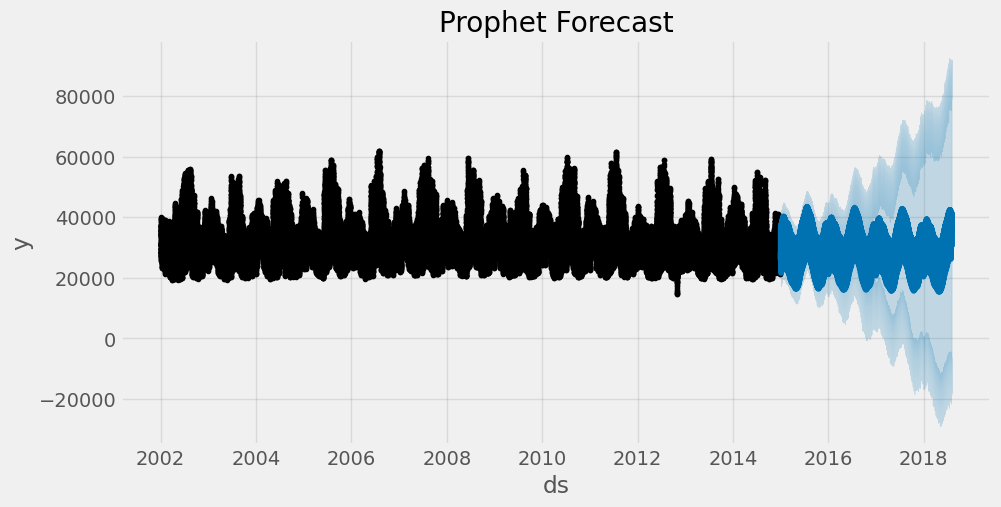

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcast, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

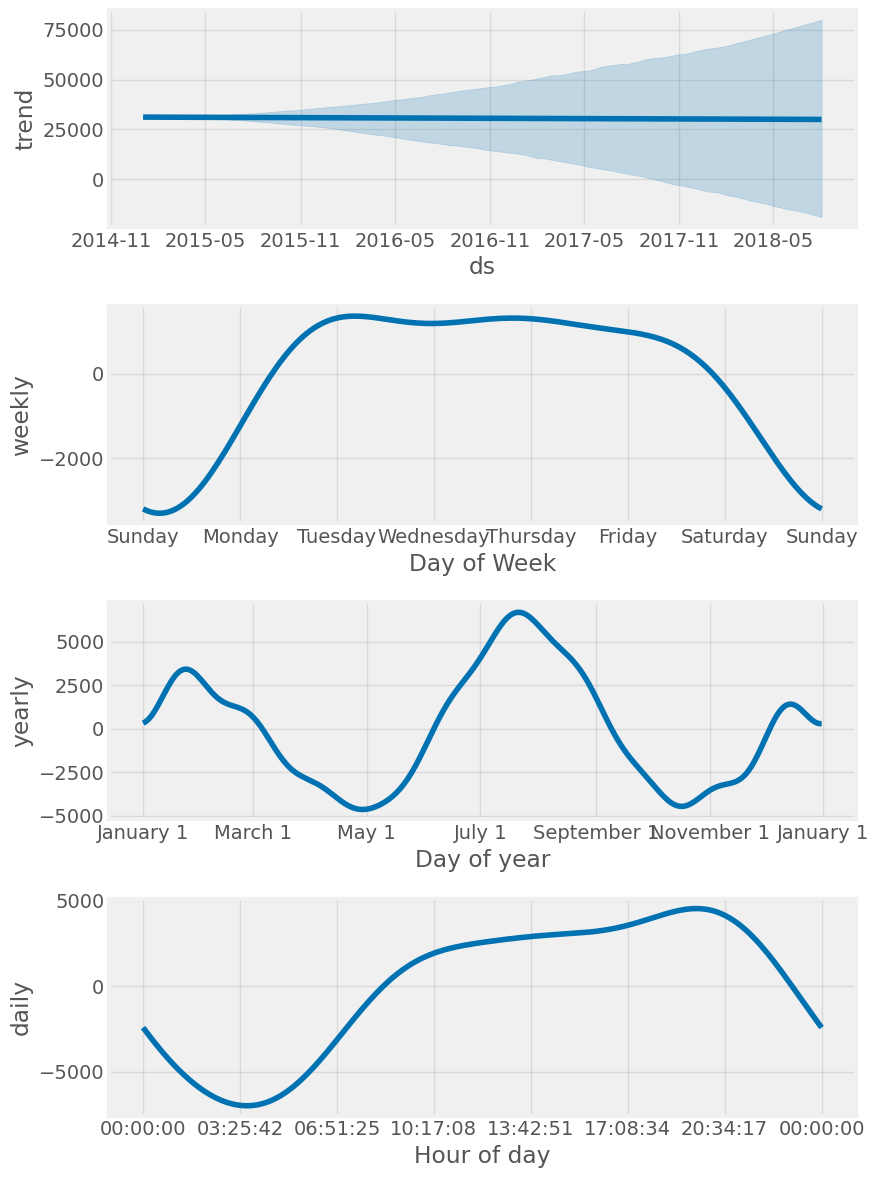

In [53]:
fig = model.plot_components(pjme_test_fcast)
plt.show()

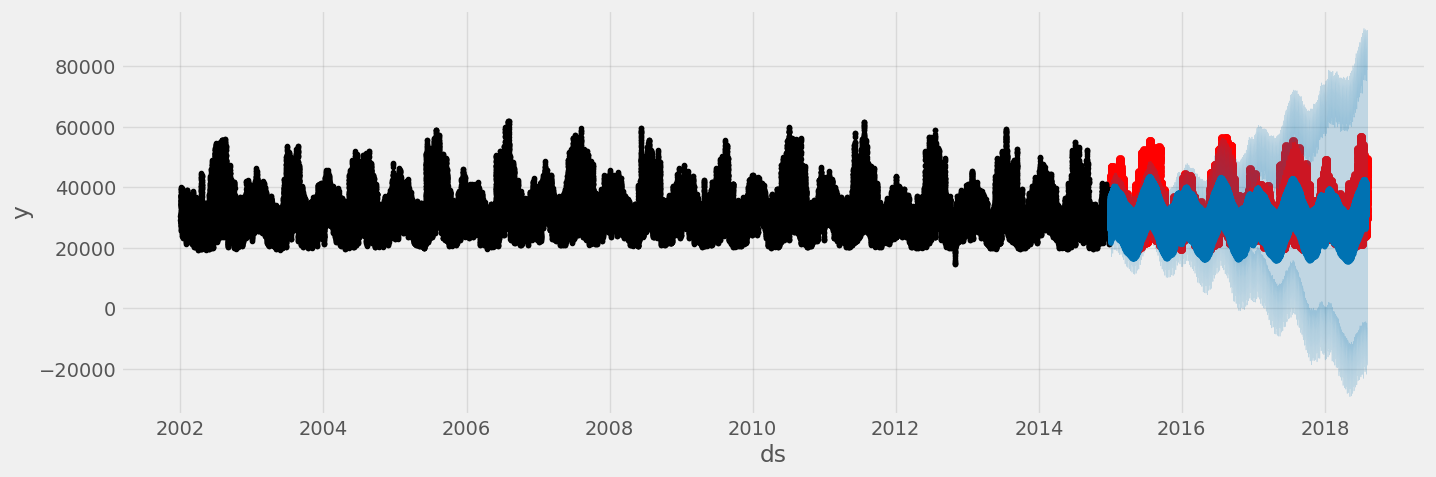

In [54]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcast, ax=ax)

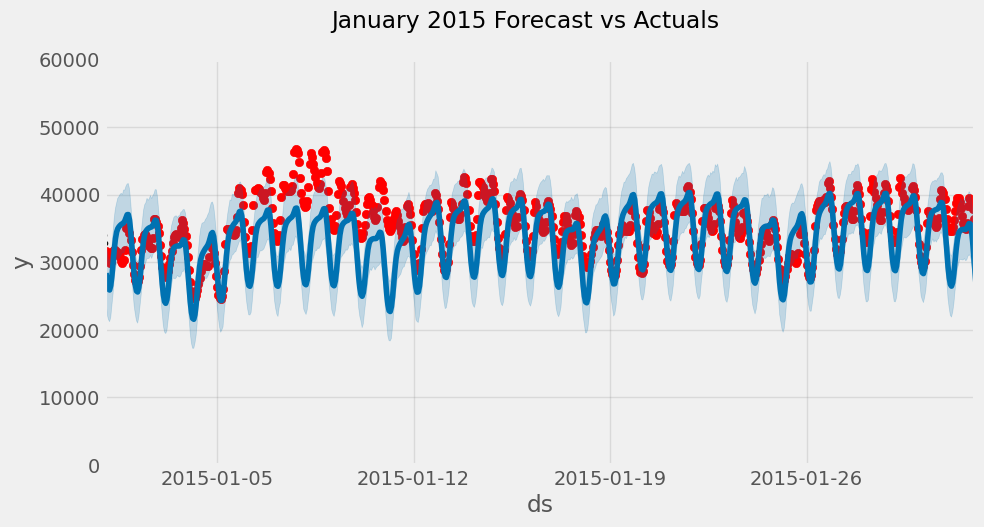

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2015'),
             upper=pd.to_datetime('02-01-2015'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

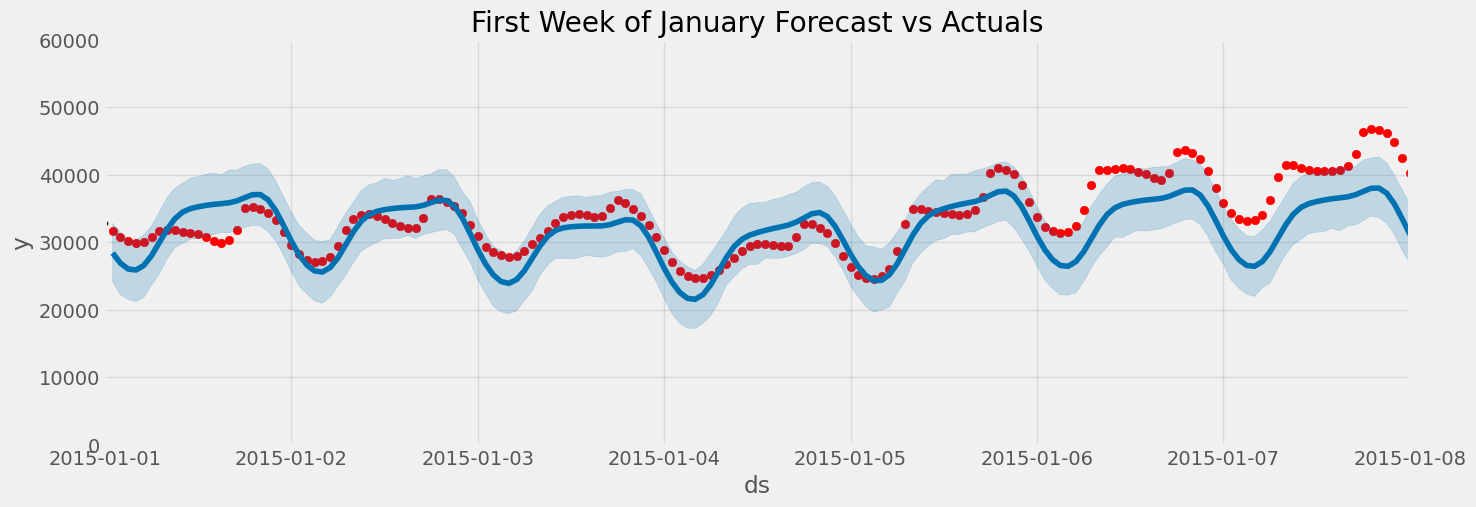

In [61]:
#Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2015'), upper=pd.to_datetime('01-08-2015'))
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

In [62]:
#Evaluate the model with Error Metrics
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                           y_pred=pjme_test_fcast['yhat']))

np.float64(6614.471677632393)

In [64]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_fcast['yhat'])

np.float64(5181.449393612847)